DOG BREED CLASSIFICATION USING AWS SAGEMAKER

This is a project to train a model that classifies different breeds of dogs in images. 133 kinds of Dogbreed dataset provided by udacity was used for the model training. A pretrained model Resnet50 from pytorch vision was tuned.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torchvision #I add this

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [22]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker done
import sagemaker
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch
from sagemaker.session import Session
from sagemaker import get_execution_role
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import os
import IPython
import io
from PIL import Image
import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [76]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-02 00:50:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  16.9MB/s    in 31s     

2022-01-02 00:51:17 (34.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [ ]:
!unzip dogImages.zip

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [23]:
sess = sagemaker.Session()
bucket= sess.default_bucket()
print("Default Bucket: {}".format(bucket))
region = sess.boto_region_name
print("AWS Region: {}".format(region))
role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-482784802372
AWS Region: us-east-1
RoleArn: arn:aws:iam::482784802372:role/service-role/AmazonSageMaker-ExecutionRole-20211213T102144


With this data we can easily sync the data up into S3!

In [24]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/myproject3/dogImages

In [7]:
import glob
print(len(glob.glob('dogImages/train/*/*')))
print(len(glob.glob('dogImages/valid/*/*')))
print(len(glob.glob('dogImages/test/*/*')))

6680
835
836


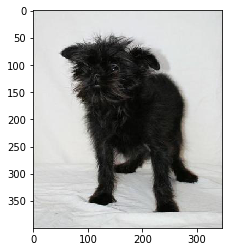

In [10]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg'));

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [17]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 6)
}

In [18]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)
objective_metric_name = "best test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "best test loss", "Regex": "Test set: best_loss: ([0-9\\.]+)"}]
    

# TODO: Your HP tuner here
tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [14]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
os.environ['SM_CHANNEL_TRAINING'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/output/'

channel = {'training': 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'}

tuner.fit(inputs=channel, wait=True) 

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [16]:
# TODO: Get the best estimators and the best HPs
tuner.best_training_job() #TODO


'pytorch-training-211231-1406-003-87e90a71'

In [30]:
tuner.best_estimator()


2021-12-31 14:45:00 Starting - Preparing the instances for training
2021-12-31 14:45:00 Downloading - Downloading input data
2021-12-31 14:45:00 Training - Training image download completed. Training in progress.
2021-12-31 14:45:00 Uploading - Uploading generated training model
2021-12-31 14:45:00 Completed - Training job completed


In [31]:
#Get the hyperparameters of the best trained model
tuner.best_estimator().hyperparameters()


2021-12-31 14:45:00 Starting - Preparing the instances for training
2021-12-31 14:45:00 Downloading - Downloading input data
2021-12-31 14:45:00 Training - Training image download completed. Training in progress.
2021-12-31 14:45:00 Uploading - Uploading generated training model
2021-12-31 14:45:00 Completed - Training job completed


{'_tuning_objective_metric': '"best test loss"',
 'batch_size': '"32"',
 'epochs': '2',
 'lr': '0.01940570610816691',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-31-14-06-42-442"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-482784802372/pytorch-training-2021-12-31-14-06-42-442/source/sourcedir.tar.gz"'}

In [12]:
hpo_best_trained_model = {"batch_size": 32, "epochs": 2, "lr": 0.01940570610816691}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs = [CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs)

In [19]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hpo_best_trained_model,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [20]:
os.environ['SM_CHANNEL_TRAINING'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/output/'

channel = {'training': 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'}

In [25]:
estimator.fit(inputs=channel, wait=True)

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


2022-01-06 19:54:42 Starting - Starting the training job...
2022-01-06 19:55:02 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-06 19:56:12 Starting - Preparing the instances for training.........
2022-01-06 19:57:38 Downloading - Downloading input data............
2022-01-06 19:59:39 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-06 20:01:00,377 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-06 20:01:00,397 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2022-01-06 20:01:00 Training - Training image download completed. Training in progress.2022-01-06 20:01:06,615 sagemaker_pytorch_container.training INFO     Invoking user trai

In [26]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader = None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


[2022-01-06 20:19:06.511 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-482784802372/pytorch-training-2022-01-06-19-54-41-183/debug-output
[2022-01-06 20:19:07.032 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-482784802372/pytorch-training-2022-01-06-19-54-41-183/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2022-01-06 20:19:13.012 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-06 20:19:14.032 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'CrossEntropyLoss_output_1'

You will find the profiler report in s3://sagemaker-us-east-1-482784802372/pytorch-training-2022-01-06-19-54-41-183/rule-output


In [27]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'CrossEntropyLoss_output_2',
 'CrossEntropyLoss_output_3',
 'CrossEntropyLoss_output_4',
 'CrossEntropyLoss_output_5',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_inpu

In [28]:
# plot the loss curve: check the next three steps
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

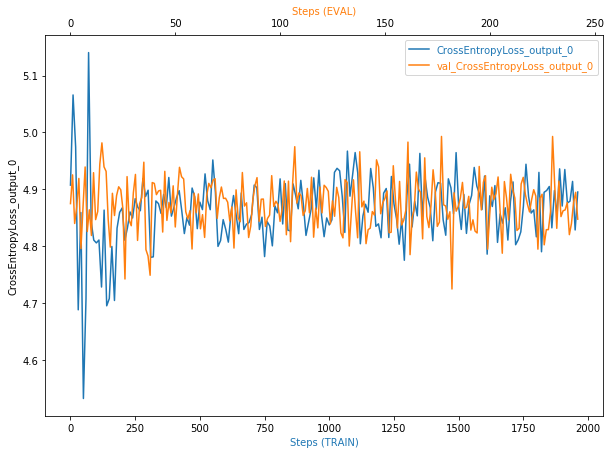

In [30]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
The anomalous behaviour in the debugging output is that the loss is up and down. The error can be fixed by tuning over a wider range of hyperparameters.
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [31]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-482784802372/pytorch-training-2022-01-06-19-54-41-183/rule-output


In [32]:
# TODO: Display the profiler output
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


2022-01-06 20:18:26     436830 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-06 20:18:25     295580 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-06 20:18:20        578 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-06 20:18:20      31060 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-06 20:18:20       2227 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-06 20:18:20        329 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-06 20:18:20       5053 pytorch-training-2022-01-06-19-54-41-183/rule-output/ProfilerReport/profiler-output/profiler-re

In [ ]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [34]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

----------!

In [5]:
with open("Affenpinscher_00003.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

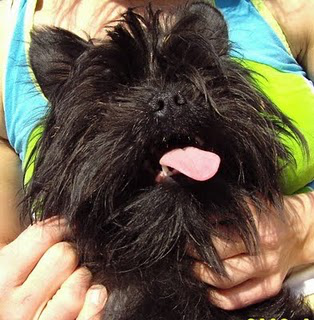

In [33]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [33]:
model_location=estimator.model_data

In [34]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [35]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [36]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [37]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [40]:
import requests
#request_dict={ "url": "https://sagemaker-us-east-1-482784802372.s3.amazonaws.com/myproject3/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }
img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

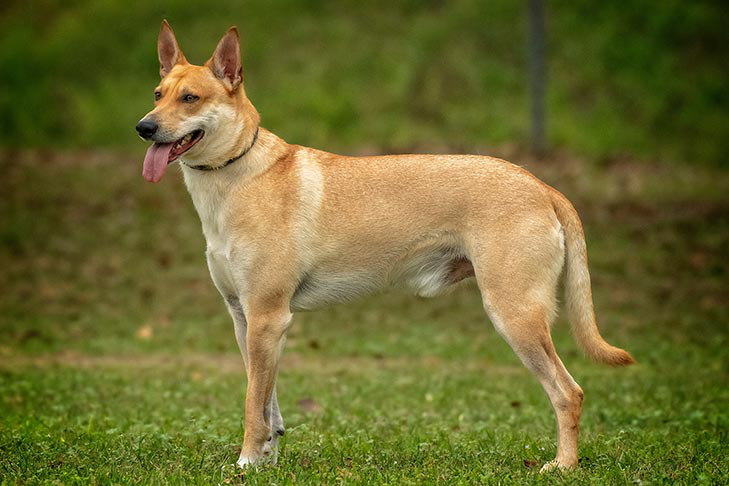

In [41]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [42]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request 1e1be9ac-9ebd-44b9-981e-0e5546a115e1.

In [ ]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [ ]:
response2[0]

In [49]:
import torch
import numpy as np
np.argmax(response, 1)

array([4])


In [86]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()